# Microgrid optimization with an algebraic approach using JuMP


An experiment which derives from the **Microgrid sizing optimization** notebook example in `../Microgrids.jl/examples/`. However, instead of doing a sizing optimization using a blackbox approach which calls the Microgrid simulator, here we use an algebraic description of the problem (using JuMP) and we run an "all-in-one" optimization of both the sizing and the energy flows at each instant.

Caveat: this yields an anticipative energy management.

PH, oct 2023

In [2]:
using Microgrids
using JuMP
using HiGHS # Linear Programming solver
using Clp
using Printf # pretty print results
#using Random, Statistics
#using CSV, DataFrames
using PyPlot

Precompiling Microgrids
  ✓ Microgrids
  1 dependency successfully precompiled in 2 seconds


## Load Microgrid project data

Loading parameters and time series for a Microgrid project with *wind* and *solar* sources, plus a *battery* and a *dispatchable generator*. 
Values gathered from the Microgrid_Wind-Solar.ipynb example notebook.

In [3]:
include("../../Microgrids.jl/examples/Microgrid_Wind-Solar_data.jl");

Data definition for Microgrid with wind, solar, storage and generator...


In [4]:
"""Create a Microgrid project description of size `x`
with x=[power_rated_gen, energy_rated_sto, power_rated_pv, power_rated_wind] in kW.

if x is omitted, x=[1,1,...] is used
"""
function create_microgrid(x)
    project = Project(lifetime, discount_rate, timestep, "€")
    # Split decision variables (converted MW → kW):
    power_rated_gen = x[1]
    energy_rated_sto = x[2]
    power_rated_pv = x[3]
    power_rated_wind = x[4]
    # Create components
    gen = DispatchableGenerator(power_rated_gen,
        fuel_intercept, fuel_slope, fuel_price,
        investment_price_gen, om_price_gen, lifetime_gen,
        load_ratio_min,
        replacement_price_ratio, salvage_price_ratio, fuel_unit)
    batt = Battery(energy_rated_sto,
        investment_price_sto, om_price_sto, lifetime_sto, lifetime_cycles,
        charge_rate, discharge_rate, loss_factor_sto, SoC_min, SoC_ini,
        replacement_price_ratio, salvage_price_ratio)
    pv = Photovoltaic(power_rated_pv, irradiance,
        investment_price_pv, om_price_pv,
        lifetime_pv, derating_factor_pv,
        replacement_price_ratio, salvage_price_ratio)
    windgen = WindPower(power_rated_wind, cf_wind,
        investment_price_wind, om_price_wind,
        lifetime_wind,
        replacement_price_ratio, salvage_price_ratio)
    mg = Microgrid(project, Pload, gen, batt, [pv, windgen])

    return mg
end

function create_microgrid()
    x1 = [1., 1., 1., 1.]
    return create_microgrid(x1)
end

create_microgrid (generic function with 2 methods)

max bounds

In [5]:
Pload_max = maximum(Pload) # kW
@printf("Max load power: %.1f kW", Pload_max)
power_rated_gen_max = 1.2 * Pload_max
energy_rated_sto_max = 10.0 * Pload_max
power_rated_pv_max = 10.0 * Pload_max
power_rated_wind_max = 5.0 * Pload_max;

Max load power: 1707.0 kW

Create Microgrid project description. Since we'll use it for sizing, it's fine if the size is set to an bad sizing.

In [6]:
mg = create_microgrid();
#K = length(mg.load) # full data length → replaced by reduced subset
dt = mg.project.timestep
#traj, stats, costs = simulate(mg)
#stats

1.0

### basic time series reduction

In [7]:
"""reduce the year time series `x` to `ndays` ≤ 365
sr=24: data sampling rate / day. 24 means hourly time step.

The method is *basic*:
it samples `ndays` days evenly spaced by (365 ÷ `ndays`) days

with ndays=365, returns the orinal series
"""
function ts_reduction(x, ndays, sr=24)
    out = zeros(ndays*sr)
    @assert ndays<=365
    Δdays = 365 ÷ ndays
    for i in 1:ndays
        offset_in = (i-1)*Δdays*sr
        offset_out = (i-1)*sr
        out[offset_out+1:offset_out+sr] = x[offset_in+1:offset_in+sr]
    end
    return out
end

ts_reduction

### Select amount of data reduction for sizing:

In [90]:
ndays = 365 # 1 to 365
K = ndays*24 # h

ts_reduction_ndays(x) = ts_reduction(x, ndays)

println("working with $ndays days, that is $K timesteps")

working with 365 days, that is 8760 timesteps


In [91]:
Pload = mg.load |> ts_reduction_ndays;

Compute capacity factor time series, i.e. normalized potential production, for wind and solar:

In [92]:
# (works because the rated power in mg are set to 1 kW)
cf_pv   = production(mg.nondispatchables[1]) |> ts_reduction_ndays
cf_wind = production(mg.nondispatchables[2]) |> ts_reduction_ndays;

### Display time series

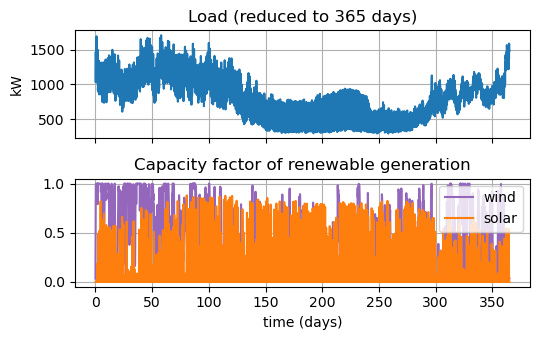

In [93]:
td = collect((0:K-1)/24) # time in days

fig, (ax1,ax2) = subplots(2,1, figsize=(5.5,3.5), sharex=true)

ax1.plot(td, Pload)
ax1.grid()
ax1.set(
    title="Load (reduced to $ndays days)",
    ylabel="kW"
)

ax2.plot(td, cf_wind, label="wind", color="tab:purple")
ax2.plot(td, cf_pv, label="solar", color="tab:orange")
ax2.grid()
ax2.legend(loc="upper right")
ax2.set(
    title="Capacity factor of renewable generation",
    xlabel="time (days)"
)

fig.tight_layout()

## JuMP optimization model

Choose between fixed lifetimes (gen and storage) vs usage-dependant:

In [177]:
fixed_lifetimes = true

true

In [136]:
optimizer = HiGHS.Optimizer
#optimizer = Clp.Optimizer
model = Model(optimizer)
set_silent(model)

### Sizing variables

4 components:

In [137]:
@variable(model, 0 <= power_rated_gen <= power_rated_gen_max)
@variable(model, 0 <= energy_rated_sto <= energy_rated_sto_max)
@variable(model, 0 <= power_rated_pv <= power_rated_pv_max)
@variable(model, 0 <= power_rated_wind <= power_rated_wind_max)

power_rated_wind

### Non dispatchable sources

In [138]:
@variable(model, pv_potential[1:K])
@constraint(model, pv_potential .== power_rated_pv*cf_pv)
@variable(model, wind_potential[1:K])
@constraint(model, wind_potential .== power_rated_wind*cf_wind);
# @variable(model, renew_potential[1:K])
# @constraint(model, renew_potential .== pv_potential .+ wind_potential);

### Net load (desired, i.e. before spillage of excess renewables and load shedding)

In [139]:
@variable(model, Pnl[1:K])
@constraint(model, Pnl .== Pload .- pv_potential .+ wind_potential);

In [140]:
@variable(model, Pspill[1:K] >= 0)
@variable(model, Pshed[1:K] >= 0);

### Dispatchable generator

In [141]:
@variable(model, Pgen[1:K] >= 0)
@constraint(model, Pgen .<= power_rated_gen);

### Energy storage

In [142]:
# Charge and discharge power
@variable(model, Psto_cha[1:K] >= 0)
@variable(model, Psto_dis[1:K] >= 0)
# Energy
@variable(model, Esto[1:K+1])
@constraint(model, Esto .<= energy_rated_sto) # SoCmax = 1 implicitly
@constraint(model, Esto .>= mg.storage.SoC_min*energy_rated_sto) # often 0
# Power constraints
@constraint(model, Psto_cha .<= mg.storage.charge_rate    * energy_rated_sto)
@constraint(model, Psto_dis .<= mg.storage.discharge_rate * energy_rated_sto)[1]

-energy_rated_sto + Psto_dis[1] ≤ 0

Evolution of the State of Energy, with piecewise linear in P loss term (aka constant efficiency model)

In [143]:
a = mg.storage.loss_factor
@constraint(model,
    stodyn[k=1:K],
    Esto[k+1] == Esto[k] + (Psto_cha[k] - Psto_dis[k] - a*(Psto_cha[k]+Psto_dis[k]))*dt
    )
stodyn[1]

stodyn[1] : -0.95 Psto_cha[1] + 1.05 Psto_dis[1] - Esto[1] + Esto[2] = 0

Storage Cyclicity

In [144]:
@constraint(model, Esto[K+1] == Esto[1])

-Esto[1] + Esto[8761] = 0

Optional: force initial SoC

In [145]:
mg.storage.SoC_ini # ...

0.0

### Power balance

at each of the `K` instants, generation should meet the load (±shedding and spillage):

In [146]:
@constraint(model, balance,  Pgen + (Psto_dis - Psto_cha) - Pspill .== Pnl - Pshed)
balance[1]

balance : -Pnl[1] - Pspill[1] + Pshed[1] + Pgen[1] - Psto_cha[1] + Psto_dis[1] = 0

Shedding limit: no shedding allowed (but could be more generally a limit on the sum of Pshed)

In [147]:
fix.(Pshed, 0.0; force=true);

### Costs

we model annualized cost, to account for the different lifetime of each component

In [148]:
"""capital recovery factor for discount rate `i` and duration `T`
CRF is such that Cann = NPC*CRF
"""
function CRF(i,T)
    if i != 0.0
        a = (1+i)^T
        return i*a/(a-1)
    else
        return 1/T
    end
end
CRF(0, 20), CRF(0.01, 20), CRF(0.05, 20), CRF(0.10, 20), CRF(0.20, 20)

(0.05, 0.055415314890551334, 0.08024258719069129, 0.11745962477254576, 0.20535653069304277)

In [149]:
discount_rate = mg.project.discount_rate

0.05

In [150]:
CRFproj(T) = CRF(discount_rate, T) 
CRFproj(20.)

0.08024258719069129

#### Generator

assumptions:
- constant efficiency, i.e. fuel intercept = 0
- (optionnally) fixed number of operating hours per year, to linearize both the O&M and investment&replacement (with fixed  lifetime)

We defined the “annualized size”, which can depend on a usage-dependant lifetime $T$: $x_{ann} = x.CRF(T(x, u))$. Otherwise, its a fixed fraction of the size:

In [178]:
if fixed_lifetimes
    # assumed generator operation hours:
    gen_hours = 3000. # in 0 – 8760
    gen_lifetime = mg.generator.lifetime_hours / gen_hours # years
    println("fixed generator lifetime: ", gen_lifetime, " y")
    Pgen_rated_ann = power_rated_gen * CRFproj(gen_lifetime)
end

fixed generator lifetime:5.0


0.23097479812826793 power_rated_gen

Generator yearly energy (compensating for the optional data reduction when `ndays` ≠  365) 

In [192]:
@variable(model, Egen >= 0)
@constraint(model, Egen == sum(Pgen)*dt * 365/ndays);

Convexified operating hours:

In [195]:
hours_factor = 2 # adjust the penalty on linearized hours
gen_hours_cvx = hours_factor*Egen/power_rated_gen

(2 Egen) / power_rated_gen

Generator cost, expressed with “annualized size” for the investment part (and normal size for O&M costs):
- *for O&M*, there is the remaining question of using fixed gen hours, or the convexified one

In [ ]:
Cgen = mg.generator.investment_price * Pgen_rated_ann +
       mg.generator.om_price_hours * gen_hours * power_rated_gen # or mg.generator.om_price_hours * hours_factor * Egen
       mg.generator.fuel_price * mg.generator.fuel_slope * Egen;# $/y

#### Battery

We defined the “annualized size”, which can depend on a usage-dependant lifetime $T$: $x_{ann} = x.CRF(T(x, u))$

In [153]:
@variable(model, Esto_rated_ann >= 0)

Esto_rated_ann

Storage cost, expressed with “annualized size” for the investment part (and normal size for O&M costs):

In [154]:
Csto = mg.storage.investment_price * Esto_rated_ann +
       mg.storage.om_price * energy_rated_sto

350 Esto_rated_ann + 10 energy_rated_sto

##### A) Effect of calendar lifetime:

In [155]:
CRFsto_cal = CRFproj(mg.storage.lifetime_calendar)
mg.storage.lifetime_calendar, CRFsto_cal

(15.0, 0.09634228760924432)

In [156]:
@constraint(model, Esto_rated_ann >= energy_rated_sto*CRFsto_cal)

-0.09634228760924432 energy_rated_sto + Esto_rated_ann ≥ 0

##### B) Effect of cycling

we define the storage yearly energy throughput $E_{through} = \sum_k (P_{sto,cha} + P_{sto,dis})\Delta_t$ (kWh/y).

Then, the storage usage is defined as:

$$U_{sto} = \frac{E_{through}}{2.N_{max}}$$

so that the storage cycling lifetime is $T = E_{rated}/U_{sto}$.

Proof:

$$ \frac{E_{rated}}{U_{sto}} = \frac{2.E_{rated}.N_{max}}{E_{through}} =  \frac{N_{max}}{N_{cycles}} $$

using the following definition for $N_{cycles}$ the yearly number of equivalent full cycles:

$$ N_{cycles} = \frac{E_{through}}{2.E_{rated}}$$

In Mg.jl:
```julia
storage_cycles = E_through_sto / 2*energy_rated_sto # cycles/y
Tsto_cycle = mg.storage.lifetime_cycles/storage_cycles # years
# thus:
Tsto_cycle = 2*mg.storage.lifetime_cycles*energy_rated_sto / E_through_sto
```

In [157]:
mg.storage.lifetime_cycles

3000.0

In [158]:
@variable(model, 0 <= Usto)
E_through_sto = (sum(Psto_cha) + sum(Psto_dis))*dt
@constraint(model, Usto == E_through_sto/(2*mg.storage.lifetime_cycles));

PWL approximation for usage-dependant annualized size:

Cut 1: long lifetime (low usage): $CRF \to i$ (discount rate).

Remark: depending on the value of the calendar lifetime, this may be inactive

In [159]:
@constraint(model, Esto_rated_ann >= energy_rated_sto*discount_rate)

-0.05 energy_rated_sto + Esto_rated_ann ≥ 0

Cut 2: turning point lifetime ($U/X \approx i/2$)

In [160]:
c = discount_rate/log(1+discount_rate)

1.0247967157143927

In [161]:
@constraint(model, Esto_rated_ann >= 
    energy_rated_sto*discount_rate*0.794486812266510 +
    Usto*c*0.724061660966310
)

-0.0397243406133255 energy_rated_sto + Esto_rated_ann - 0.7420160121329825 Usto ≥ 0

Cut 3: low lifetime (high usage)

In [162]:
@constraint(model, Esto_rated_ann >= 
    energy_rated_sto*discount_rate*0.5 +
    Usto*c
)

-0.025 energy_rated_sto + Esto_rated_ann - 1.0247967157143927 Usto ≥ 0

#### Wind and solar

In [163]:
pv = mg.nondispatchables[1];

In [164]:
Cpv = pv.investment_price * power_rated_pv * CRFproj(pv.lifetime) + 
      pv.om_price * power_rated_pv

105.14294875907551 power_rated_pv

In [165]:
wind = mg.nondispatchables[2];

In [166]:
Cwind = wind.investment_price * power_rated_wind * CRFproj(wind.lifetime) + 
        wind.om_price * power_rated_wind

348.3336005473036 power_rated_wind

In [167]:
Cann = Cgen + Csto +  Cpv + Cwind;

In [168]:
@objective(model, Min, Cann);

Display model stats: number of variables, constraints...

- calendard storage lifetime only: 78845 variables
- adding usage dependant: 78847 variables (Usto, Esto_ann)

In [169]:
model

A JuMP Model
Minimization problem with:
Variables: 78847
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 43802 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 8765 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 35041 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 8760 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 35046 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 4 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: Esto, Esto_rated_ann, Pgen, Pnl, Pshed, Pspill, Psto_cha, Psto_dis, Usto, balance, energy_rated_sto, power_rated_gen, power_rated_pv, power_rated_wind, pv_potential, stodyn, wind_potential

## Optimize

Takes:
- 4.6 s with 365 days with HiGHS
- 5.6 s with 365 days with Clp

with usage dependant cycling:

- 22.8 s (but on battery, on Leno i5)

In [170]:
println(optimizer, " K=", K)
@time optimize!(model)

HiGHS.Optimizer K=8760
 22.785528 seconds (955.43 k allocations: 96.073 MiB)


In [171]:
LCOE_opt = value(Cann)/(sum(Pload)*dt)
@printf("LCOE*: %.6f \$/kWh\n", LCOE_opt)

LCOE*: 0.248019 $/kWh


Old run (calendar lifetime only)

- fixed lifetime: LCOE* 0.248019 $/kWh for both HiGHS and Clp
- with battery cycling aging: same (unchanged, cycling limit not active)

### Optimal sizing
oddly enough, no wind, but perhaps this is due to underpriced generator

HiGHS sizing: (1310.9604758128346, 1651.9820031721902, 2225.349262011582, 0.0)

In [172]:
value(power_rated_gen), value(energy_rated_sto), value(power_rated_pv), value(power_rated_wind)

(1310.9604758128341, 1651.9820031722054, 2225.3492620115926, 0.0)

Cycling lifetime:

In [173]:
value(energy_rated_sto/Usto)

15.368919909700779

In [174]:
value(E_through_sto/(2*energy_rated_sto)) # c/year

195.19914331171782

In [175]:
3000/195

15.384615384615385

Generator hours:

In [186]:
gen_hours_actual = sum(value.(Pgen) .> 1e-3*value(power_rated_gen) )*dt
gen_hours_lin_actual = 2*sum(value.(Pgen)./value(power_rated_gen))*dt
gen_hours_actual, gen_hours_lin_actual

(6791.0, 7464.879154316371)

### Plot trajectory

In [183]:
function plot_oper_traj(td, Pload, Pgen, Pren, Ebatt, price)
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(5,3), sharex=true)
    ax1.plot(td, Pload, label="load")
    ax1.plot(td, Pgen, "tab:red", label="gen")
    ax1.plot(td, Pren, "tab:green", label="renew")
    ax2.plot(td, Ebatt[1:end-1], "C2", label="Esto")
    
    ax1.legend()
    ax1.grid(true)
    ax1.set(
        ylabel="kW"
    )
    ax2.grid(true)
    ax2.legend()
    ax2.set(
        ylabel="kWh"
    )

    ax3.plot(td, price, color="tab:brown", label="price")
    ax3.grid(true)
    ax3.legend()
    ax3.set(
        xlabel="time (d)",
        ylabel="\$/kWh"
    )
    
    fig.tight_layout()
    return fig, (ax1, ax2, ax3)
end

plot_oper_traj (generic function with 3 methods)

In [184]:
pygui(true) # open interactive plot window
pygui(false) # display image in notebook

false

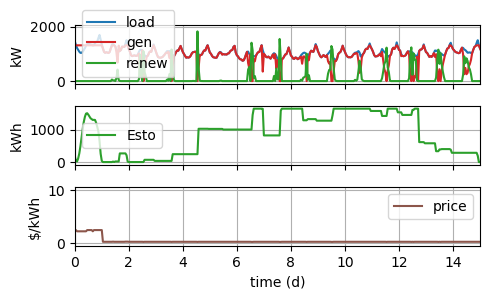

In [185]:
fig, (ax1, ax2, ax3) = plot_oper_traj(td, load, value.(Pgen),
    value.(pv_potential+wind_potential),
    value.(Esto),
    dual.(balance)
)
ax1.set_xlim(0, 15);

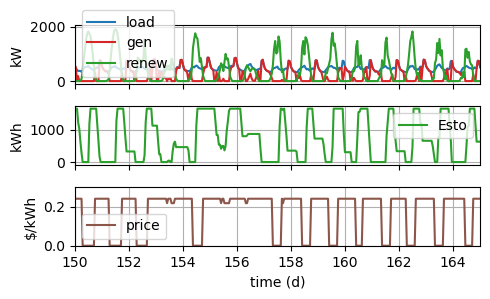

In [188]:
fig, (ax1, ax2, ax3) = plot_oper_traj(td, load, value.(Pgen),
    value.(pv_potential+wind_potential),
    value.(Esto),
    dual.(balance)
)
ax1.set_xlim(150, 165);
ax3.set_ylim(0, 0.3); # zoom on shadow price

🚧 **Optim results analysis: TO BE CONTINUED....** 🚧

TODO:
- compute *actual* lifetime of generator and battery (cycles)
- compute cost table
- work on usage-dependant cost modeling

## Timing analysis

TO BE DONE

effect on optimization time of: 
- ndays
- solver (HiGHS, Clp, Gurobi)